# Let's pull some data...

In [ ]:
!if [ ! -f ChestXRay2017.zip ]; then gdown --fuzzy https://drive.google.com/file/d/1jf1XvAeXPD4XAerknz5inxM0StuCNbyX/view?usp=sharing; unzip ChestXRay2017.zip; fi

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/PNEUMONIA/person1562_bacteria_4078.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person802_bacteria_2708.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person902_bacteria_2827.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person825_bacteria_2736.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1733_bacteria_4566.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person28_bacteria_141.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person494_bacteria_2090.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1088_virus_1800.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person62_bacteria_300.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1328_virus_2295.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1109_bacteria_3050.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person554_bacteria_2320.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person573_bacteria_2369.jpeg  
  inflating: chest_xray/train/P

# Let's Train a CNN

In [ ]:
from __future__ import print_function
import os
import time
import copy
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [ ]:
show        = True
pretrain    = False
data_dir    = 'chest_xray'
batch_size  = 4            # Number of samples in each batch
num_workers = 4
epoch_num   = 25           # Number of epochs to train the network
lr          = 1e-3         # Learning rate

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomResizedCrop(size=(300,300),antialias=True)
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomResizedCrop(size=(300,300),antialias=True)
    ]),
}

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                  data_transforms[x])
                for x in ['train', 'test']}
#print(image_datasets)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
              shuffle=True, num_workers=4)
              for x in ['train', 'test']}

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)

{'train': 5232, 'test': 624}


In [ ]:
class_names = image_datasets['train'].classes
#inputs, classes = next(iter(dataloaders['train']))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: %s" %device)
print("classes: %s" %class_names)

device: cuda
classes: ['NORMAL', 'PNEUMONIA']


In [ ]:
def imshow(inp, title=None, fname=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if show is True:
        plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    if fname is not None:
        plt.savefig('%s' %fname)

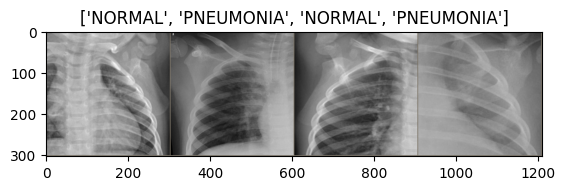

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('%s Epoch [%d]/[%d] running loss: %.6f Acc:%.6f' %
                      (phase, epoch + 1, num_epochs, running_loss/len(dataloaders[phase]),epoch_acc))
            running_loss = 0.0


            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            #    phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print('actual labels')

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                #print(class_names[labels[j]])
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                fig.tight_layout()
                ax.axis('off')
                ax.set_title('predicted: {}\nactual: {}' .format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j],fname='model_predict.jpg')



                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=pretrain)
if torch.cuda.device_count() > 1:
    print("Using ", torch.cuda.device_count(),"gpus!")
    model_ft = nn.DataParallel(model_ft) #

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft=model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epoch_num)

train Epoch [1]/[25] running loss: 1.935312 Acc:0.786697
test Epoch [1]/[25] running loss: 2.745267 Acc:0.727564

train Epoch [2]/[25] running loss: 1.708586 Acc:0.811735
test Epoch [2]/[25] running loss: 2.962744 Acc:0.714744

train Epoch [3]/[25] running loss: 1.486366 Acc:0.835627
test Epoch [3]/[25] running loss: 2.681449 Acc:0.679487

train Epoch [4]/[25] running loss: 1.349342 Acc:0.860665
test Epoch [4]/[25] running loss: 2.061598 Acc:0.810897

train Epoch [5]/[25] running loss: 1.158407 Acc:0.882072
test Epoch [5]/[25] running loss: 1.534644 Acc:0.839744

train Epoch [6]/[25] running loss: 1.111394 Acc:0.886468
test Epoch [6]/[25] running loss: 2.691275 Acc:0.799679

train Epoch [7]/[25] running loss: 1.119065 Acc:0.890099
test Epoch [7]/[25] running loss: 1.321176 Acc:0.868590

train Epoch [8]/[25] running loss: 0.904345 Acc:0.913609
test Epoch [8]/[25] running loss: 1.638307 Acc:0.847756

train Epoch [9]/[25] running loss: 0.873736 Acc:0.918196
test Epoch [9]/[25] running los

Mounted at /content/drive


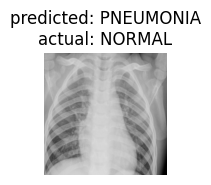

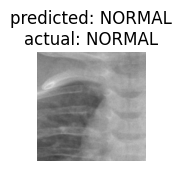

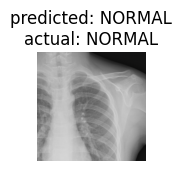

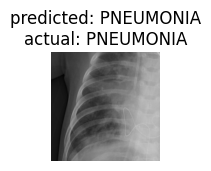

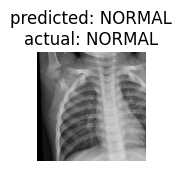

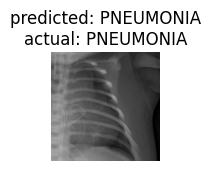

<Figure size 640x480 with 0 Axes>

In [ ]:
# Mount Google Drive
from google.colab import drive

drive.mount('/content/drive')

# Directory in Google Drive to save the model
base_dir = '/content/drive/My Drive/Colab Notebooks/models'
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

# Path to save the model
filename = os.path.join(base_dir, 'model.pth')

# Save the model
torch.save(model_ft.state_dict(), filename)

# Visualize the model (optional)
visualize_model(model_ft)

[[179  55]
 [ 40 350]]
[76.4957265  89.74358974]


Text(0.5, 1.0, 'Confusion Matrix')

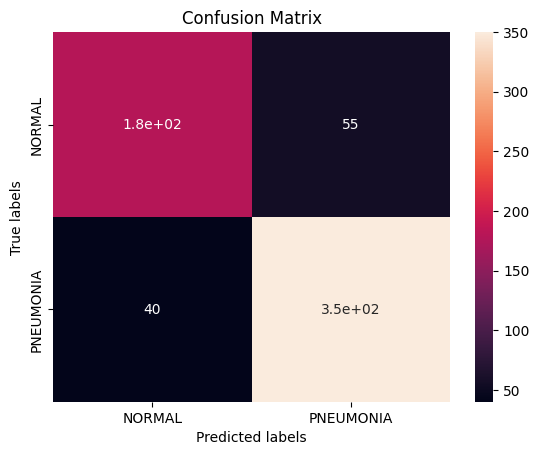

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)
ax= plt.subplot()


sns.heatmap(conf_mat, annot=True)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
ax.set_title('Confusion Matrix')

# Time to Open the Box with Captum...

In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.7 MB/s eta 0:00:00


In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image

# Visualized Image and Classification Prediction Score

In [ ]:
data_dir = 'chest_xray/test'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model_ft #torch.load('/content/models/model.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import os
import random

image_directory = '/content/chest_xray/test/PNEUMONIA/'

# List all files in the directory
image_files = [f for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]

# Select a random image file
random_image_file = random.choice(image_files)

# Open the random image
img = Image.open(os.path.join(image_directory, random_image_file)).convert('RGB')

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.RandomResizedCrop(size=(300, 300), antialias=True),  # Crop the image
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

transformed_img = transform(img)

# Add a batch dimension and send the input to the device
input_tensor = transformed_img.unsqueeze(0).to(device)
print(input_tensor.size())

torch.Size([1, 3, 300, 300])


Predicted: PNEUMONIA ( 0.8600974678993225 )


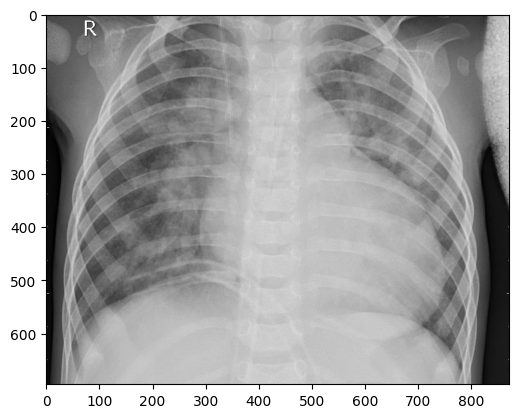

In [ ]:
output = model_ft(input_tensor)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

classes = class_names
pred_label_idx.squeeze_()
predicted_label = classes[pred_label_idx.item()]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
plt.figure()
plt.imshow(img)

In [ ]:
integrated_gradients = IntegratedGradients(model_ft)
attributions_ig = integrated_gradients.attribute(input_tensor, target=pred_label_idx, n_steps=100)

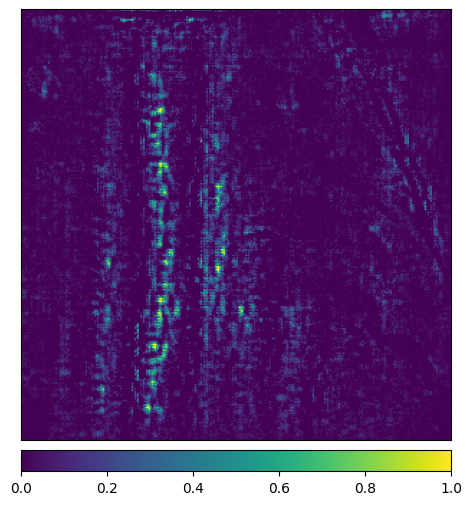

In [ ]:
# Consider using a predefined colormap for better visibility and accessibility
cmap = plt.cm.viridis

# Helper function to simplify tensor preparation
def prepare_tensor_for_visualization(tensor):
    return np.transpose(tensor.squeeze().cpu().detach().numpy(), (1, 2, 0))

# Apply the helper function
attributions_prepared = prepare_tensor_for_visualization(attributions_ig)
transformed_img_prepared = prepare_tensor_for_visualization(transformed_img)

# Visualize the image attributes
viz_result = viz.visualize_image_attr(attributions_prepared,
                                      transformed_img_prepared,
                                      method='heat_map',
                                      cmap=cmap,
                                      show_colorbar=True,
                                      sign='positive',
                                      outlier_perc=1)

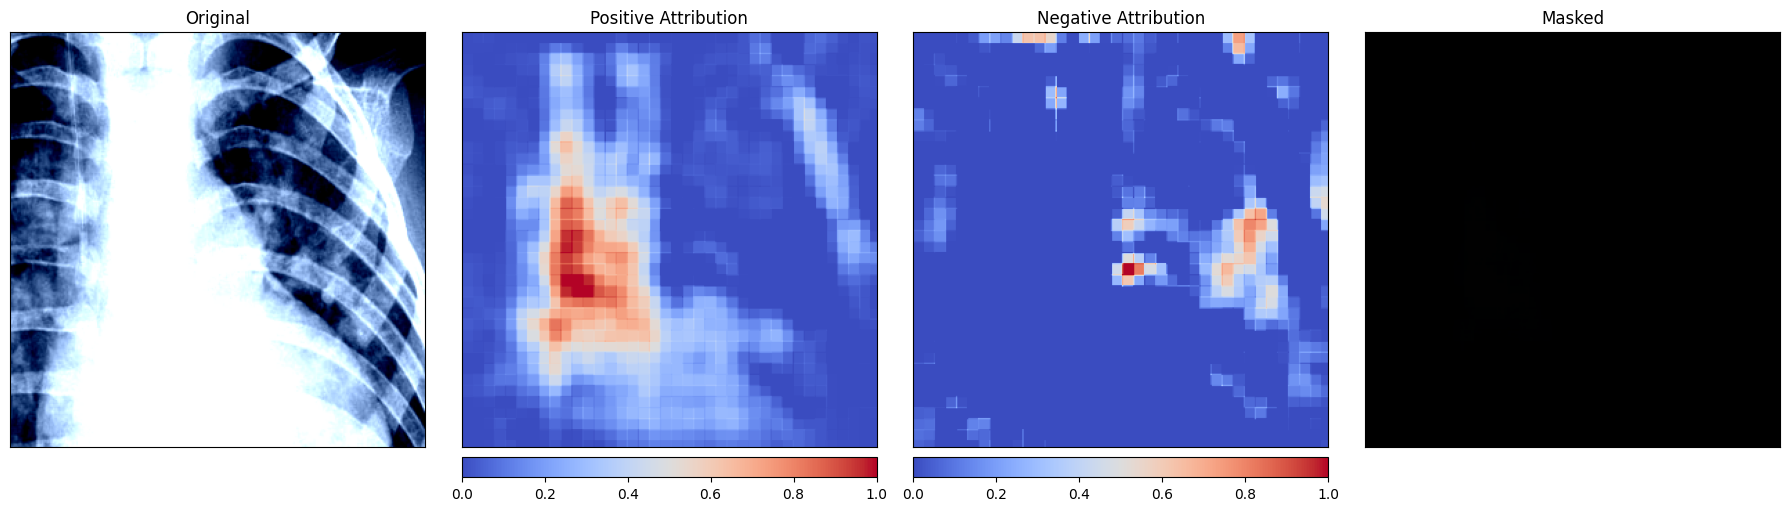

(<Figure size 1800x600 with 8 Axes>,
 array([<Axes: title={'center': 'Original'}>,
        <Axes: title={'center': 'Positive Attribution'}>,
        <Axes: title={'center': 'Negative Attribution'}>,
        <Axes: title={'center': 'Masked'}>], dtype=object))

In [ ]:
occlusion = Occlusion(model)

from matplotlib import pyplot as plt

# Utility function for preparing tensor for visualization
def prepare_for_visualization(tensor):
    return np.transpose(tensor.squeeze().cpu().detach().numpy(), (1, 2, 0))

# Parameter explanations
# strides: Steps for sliding the window across each dimension of the input image.
# sliding_window_shapes: The size of the occlusion window.
# baselines: The value used to replace the occluded window. Here, 0 implies a black window.

attributions_occ = occlusion.attribute(input_tensor,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0,
                                       target=pred_label_idx)

# Prepare attributions and the original image for visualization
attributions_prepared = prepare_for_visualization(attributions_occ)
original_img_prepared = prepare_for_visualization(transformed_img)

# Visualize the attributions
viz.visualize_image_attr_multiple(attributions_prepared,
                                  original_img_prepared,
                                  methods=["original_image", "heat_map", "heat_map", "masked_image"],
                                  signs=["all", "positive", "negative", "positive"],
                                  cmap='coolwarm',  # Enhanced color map for visibility
                                  show_colorbar=True,
                                  titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                  fig_size=(18, 6)
                                 )
